In [1]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_context('poster')

In [3]:
pip install -U tbparse


[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
ls ../_one2one/*

../_one2one/4cls-chinese_lr1e-5_dmn-MCL:
tensorboard-2024_11_16-19_30_23/

../_one2one/4cls-chinese_lr1e-5_MCL:
tensorboard-2024_11_16-19_31_01/

../_one2one/4cls-english_lr1e-5_dmn-MCL:
tensorboard-2024_11_16-19_30_23/

../_one2one/4cls-english_lr1e-5_MCL:
tensorboard-2024_11_16-19_31_01/

../_one2one/4cls-german_lr1e-5_dmn-MCL:
tensorboard-2024_11_16-19_31_06/

../_one2one/4cls-german_lr1e-5_MCL:
tensorboard-2024_11_16-19_31_01/

../_one2one/4cls-norwegian_lr1e-5_dmn-MCL:
tensorboard-2024_11_16-19_31_02/

../_one2one/4cls-norwegian_lr1e-5_MCL:
tensorboard-2024_11_16-19_31_01/

../_one2one/4cls-russian_lr1e-5_dmn-MCL:
tensorboard-2024_11_16-19_31_02/

../_one2one/4cls-russian_lr1e-5_MCL:
tensorboard-2024_11_16-19_31_02/

../_one2one/4cls-spanish_lr1e-5_dmn-MCL:
tensorboard-2024_11_16-19_31_02/

../_one2one/4cls-spanish_lr1e-5_MCL:
tensorboard-2024_11_16-19_31_02/

../_one2one/4cls-swedish_lr1e-5_dmn-MCL:
tensorboard-2024_11_16-19_31_01/

../_one2one/4cls-swedish_lr1e-5_MCL:
tensorboar

In [27]:
from tbparse import SummaryReader
from pathlib import Path
dfs = []
# for p in Path('../_one2one/').glob('WIC_DWUG+XLWSD+CoMeDi_*'):
for p in Path('../_4class/').glob('WIC_DWUG+XLWSD+CoMeDi_*'):
    reader = SummaryReader(p)
    df = reader.scalars
    df['path'] = str(p)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

df.tag.value_counts()

tag
4class_accuracy.average.score                   1779
batch_size                                      1779
learning_rate                                   1779
krippendorff_alpha.average.score                1779
global_step                                     1779
eval_total_loss                                 1779
epoch                                           1779
accuracy.average.score                          1779
train_total_loss                                1430
4class_accuracy.dev.comedi_chinese.score        1430
dev.comedi_spanish.krippendorff_alpha           1430
dev.comedi_russian.krippendorff_alpha           1430
dev.comedi_norwegian.krippendorff_alpha         1430
dev.comedi_german.krippendorff_alpha            1430
dev.comedi_english.krippendorff_alpha           1430
dev.comedi_chinese.krippendorff_alpha           1430
dev.comedi_swedish.krippendorff_alpha           1430
4class_accuracy.dev.comedi_norwegian.score      1430
accuracy.dev.comedi_swedish.score         

In [3]:
df.head()

,step,tag,value,path
0,46,4class_accuracy.average.score,0.108164,../_4class/WIC_DWUG+XLWSD+CoMeDi_english_4
1,92,4class_accuracy.average.score,0.109559,../_4class/WIC_DWUG+XLWSD+CoMeDi_english_4
2,138,4class_accuracy.average.score,0.113920,../_4class/WIC_DWUG+XLWSD+CoMeDi_english_4
3,184,4class_accuracy.average.score,0.101264,../_4class/WIC_DWUG+XLWSD+CoMeDi_english_4
4,184,4class_accuracy.average.score,0.149915,../_4class/WIC_DWUG+XLWSD+CoMeDi_english_4


In [4]:
lang2dev = {p.name.split('.')[0]:pd.read_json(p) 
            for p in Path('../comedi_dataset_all/dev/').glob('*.gold')}

/home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


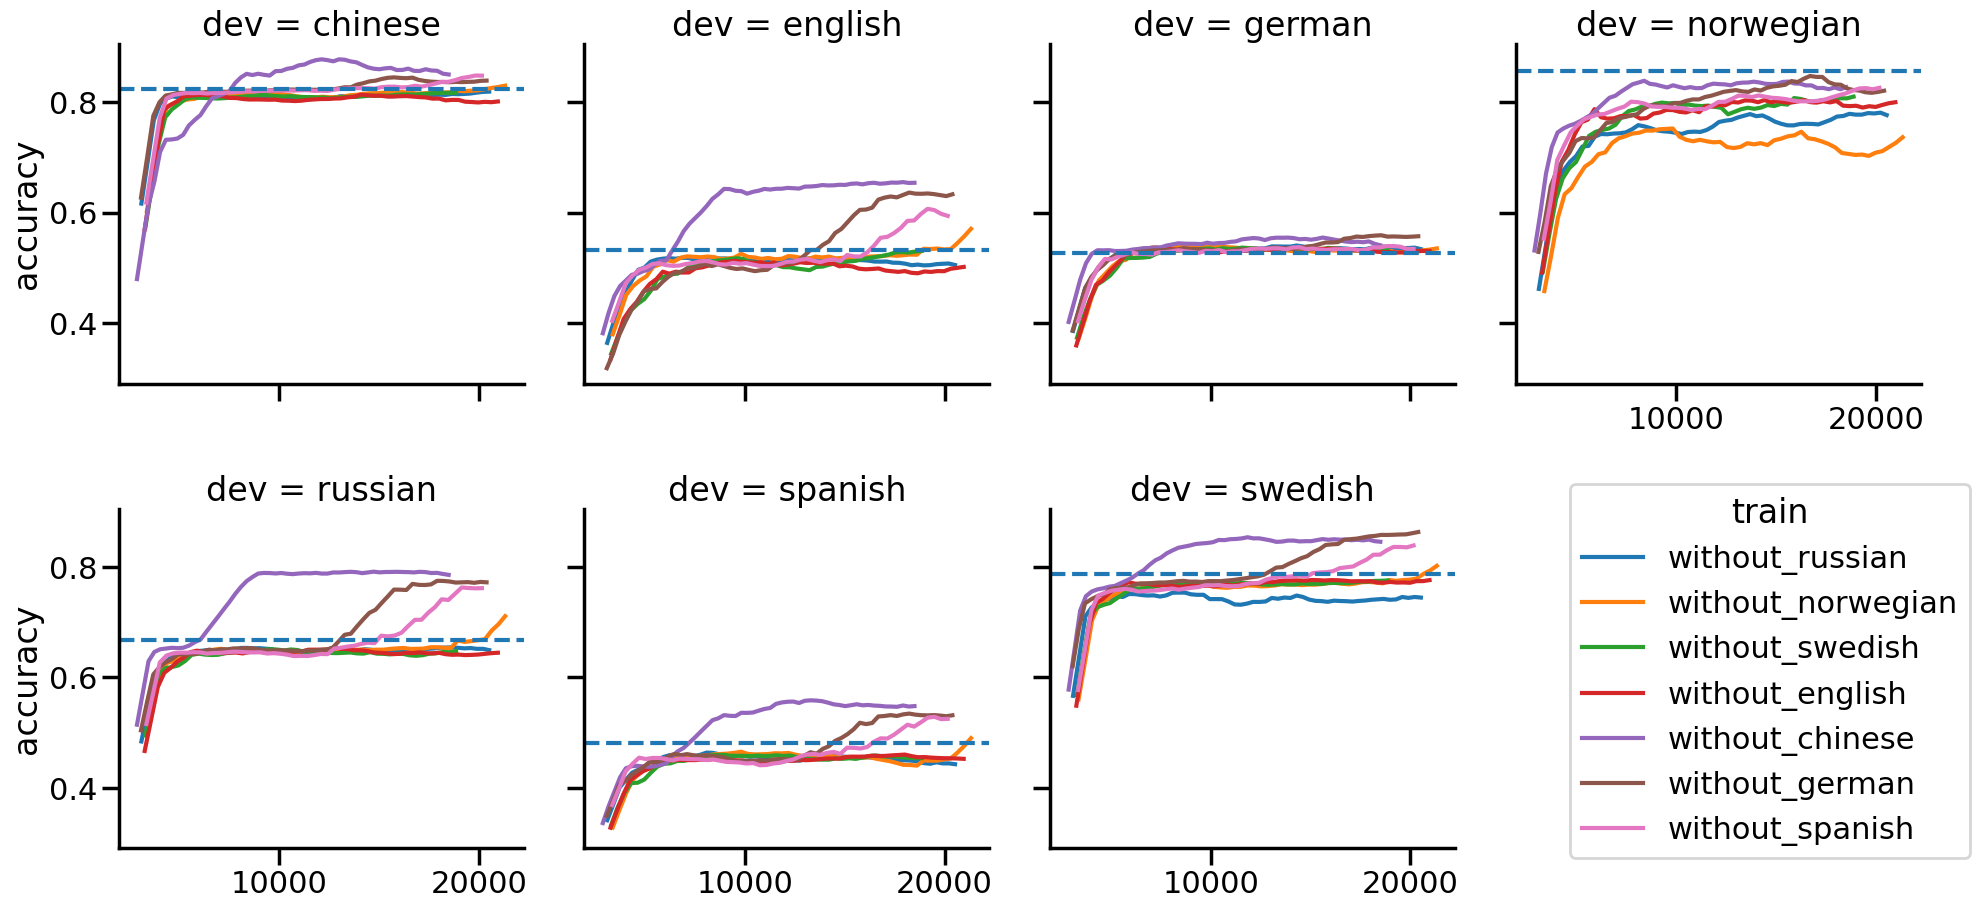

In [22]:
pdf = df[df.tag.str.startswith('4class_accuracy.dev') &
         df.path.str.contains('without')].copy()
pdf['dev'] = pdf.tag.str.extract('comedi_([a-z]*).')
pdf['train'] = pdf.path.str.extract('CoMeDi_(.*)_4')
pdf['accuracy'] = pdf.sort_values(by='step').groupby(['train','dev'])['value'].transform(lambda s:
                                                                                          s.rolling(10).mean())
devsets = list(pdf.dev.unique())
g = sns.relplot(data=pdf[pdf.step>1000], y='accuracy', x='step', hue='train', col='dev', 
            kind='line', col_wrap=4, col_order=devsets)
sns.move_legend(g, 'lower right',  bbox_to_anchor=(0.85, 0.1), frameon=True)
g.set_xlabels('')
for lang, ax in zip(devsets,g.axes.flatten()):
    mfc_baseline = lang2dev[lang].score.value_counts(normalize=True).loc[4]
    ax.axhline(mfc_baseline, ls='--')

/home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


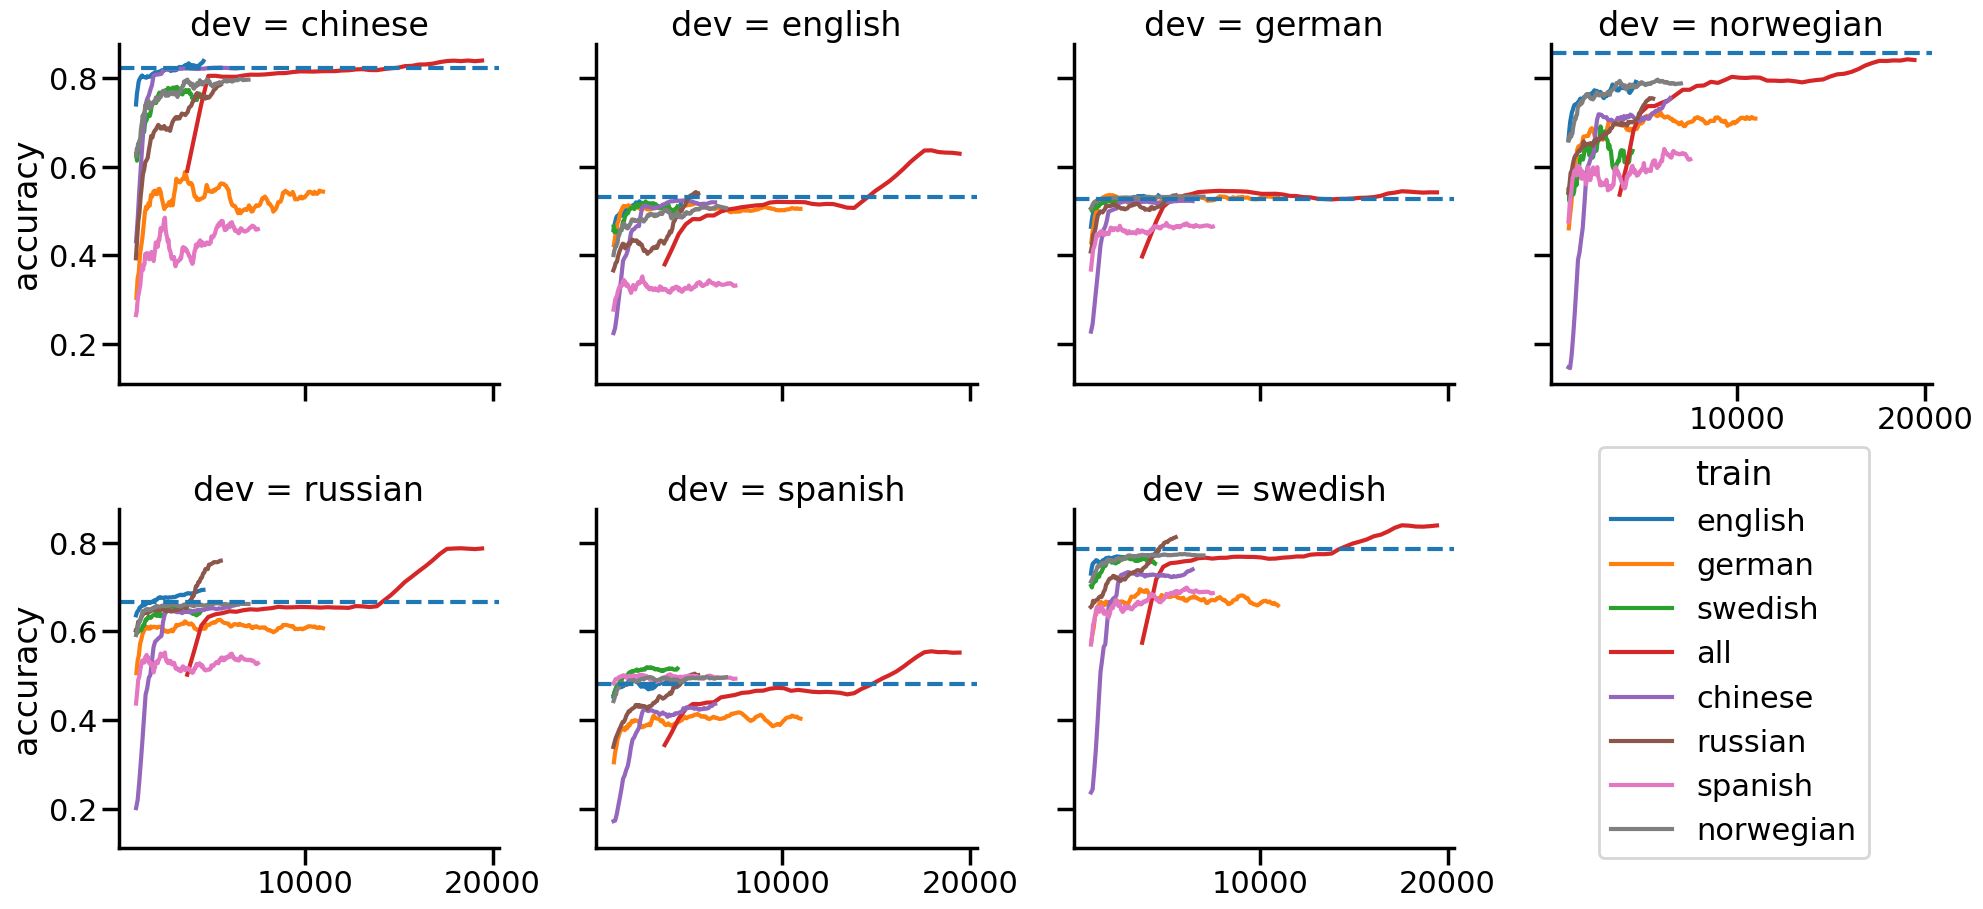

In [6]:
# pdf = df[df.tag.str.startswith('4class_accuracy.dev') & 
#          (df.path.str.contains('without') | df.path.str.contains('all'))].copy()

pdf = df[df.tag.str.startswith('4class_accuracy.dev') &
         ~df.path.str.contains('without')].copy()
pdf['dev'] = pdf.tag.str.extract('comedi_([a-z]*).')
pdf['train'] = pdf.path.str.extract('CoMeDi_(.*)_4')
pdf['accuracy'] = pdf.sort_values(by='step').groupby(['train','dev'])['value'].transform(lambda s:
                                                                                          s.rolling(10).mean())
devsets = list(pdf.dev.unique())
g = sns.relplot(data=pdf[pdf.step>1000], y='accuracy', x='step', hue='train', col='dev', 
            kind='line', col_wrap=4, col_order=devsets)
sns.move_legend(g, 'lower right',  bbox_to_anchor=(0.85, 0.1), frameon=True)
g.set_xlabels('')
for lang, ax in zip(devsets,g.axes.flatten()):
    mfc_baseline = lang2dev[lang].score.value_counts(normalize=True).loc[4]
    ax.axhline(mfc_baseline, ls='--')

/home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


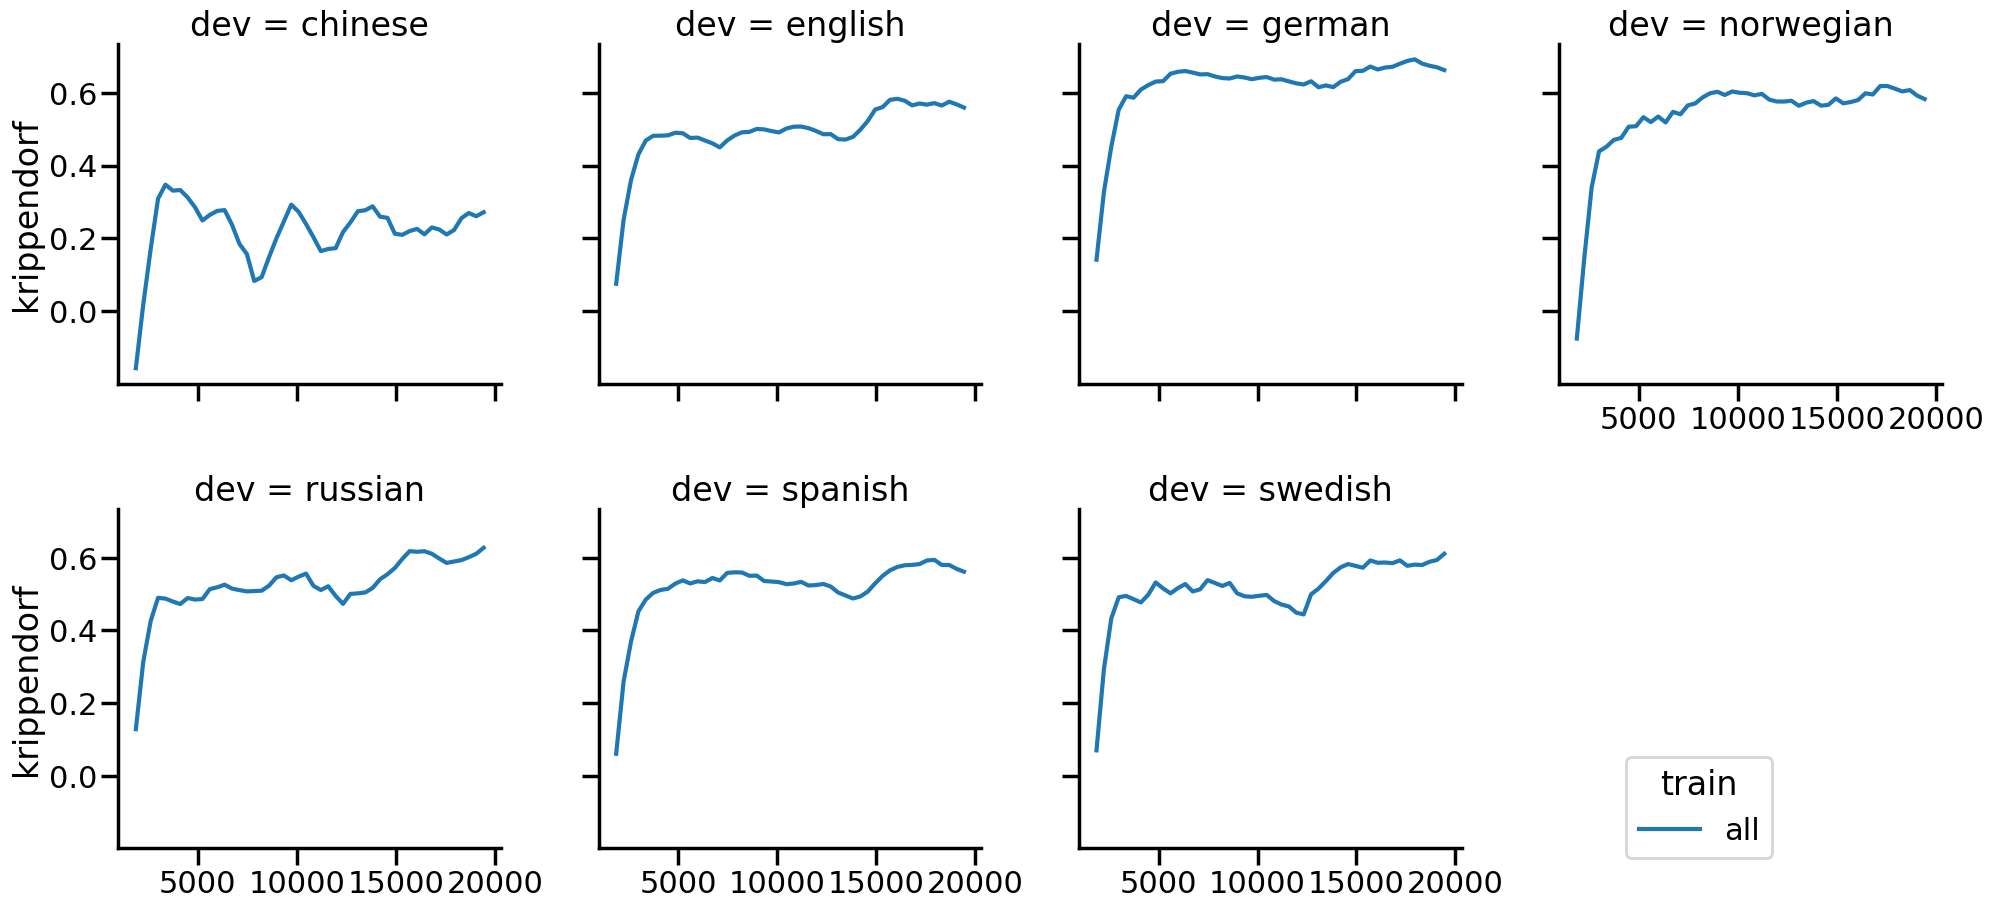

In [24]:
# pdf = df[df.tag.str.startswith('dev') & df.path.str.contains('without')].copy()
pdf = df[df.tag.str.startswith('dev') &
         (df.path.str.contains('without') | df.path.str.contains('all'))].copy()
pdf['dev'] = pdf.tag.str.extract('comedi_(.*).krippendorff')
pdf['train'] = pdf.path.str.extract('CoMeDi_([a-z]*)_4')
pdf['krippendorf'] = pdf.sort_values(by='step').groupby(['train','dev'])['value'].transform(lambda s:                                                                                              s.rolling(5).mean())

g = sns.relplot(data=pdf[pdf.step>1000], y='krippendorf', x='step', hue='train', col='dev', 
            kind='line', col_wrap=4)
sns.move_legend(g, 'lower right',  bbox_to_anchor=(0.85, 0.1), frameon=True)
g.set_xlabels('')
g.savefig('4class-one2one.pdf')

/home/nikolare/anaconda3/envs/jupyterai/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


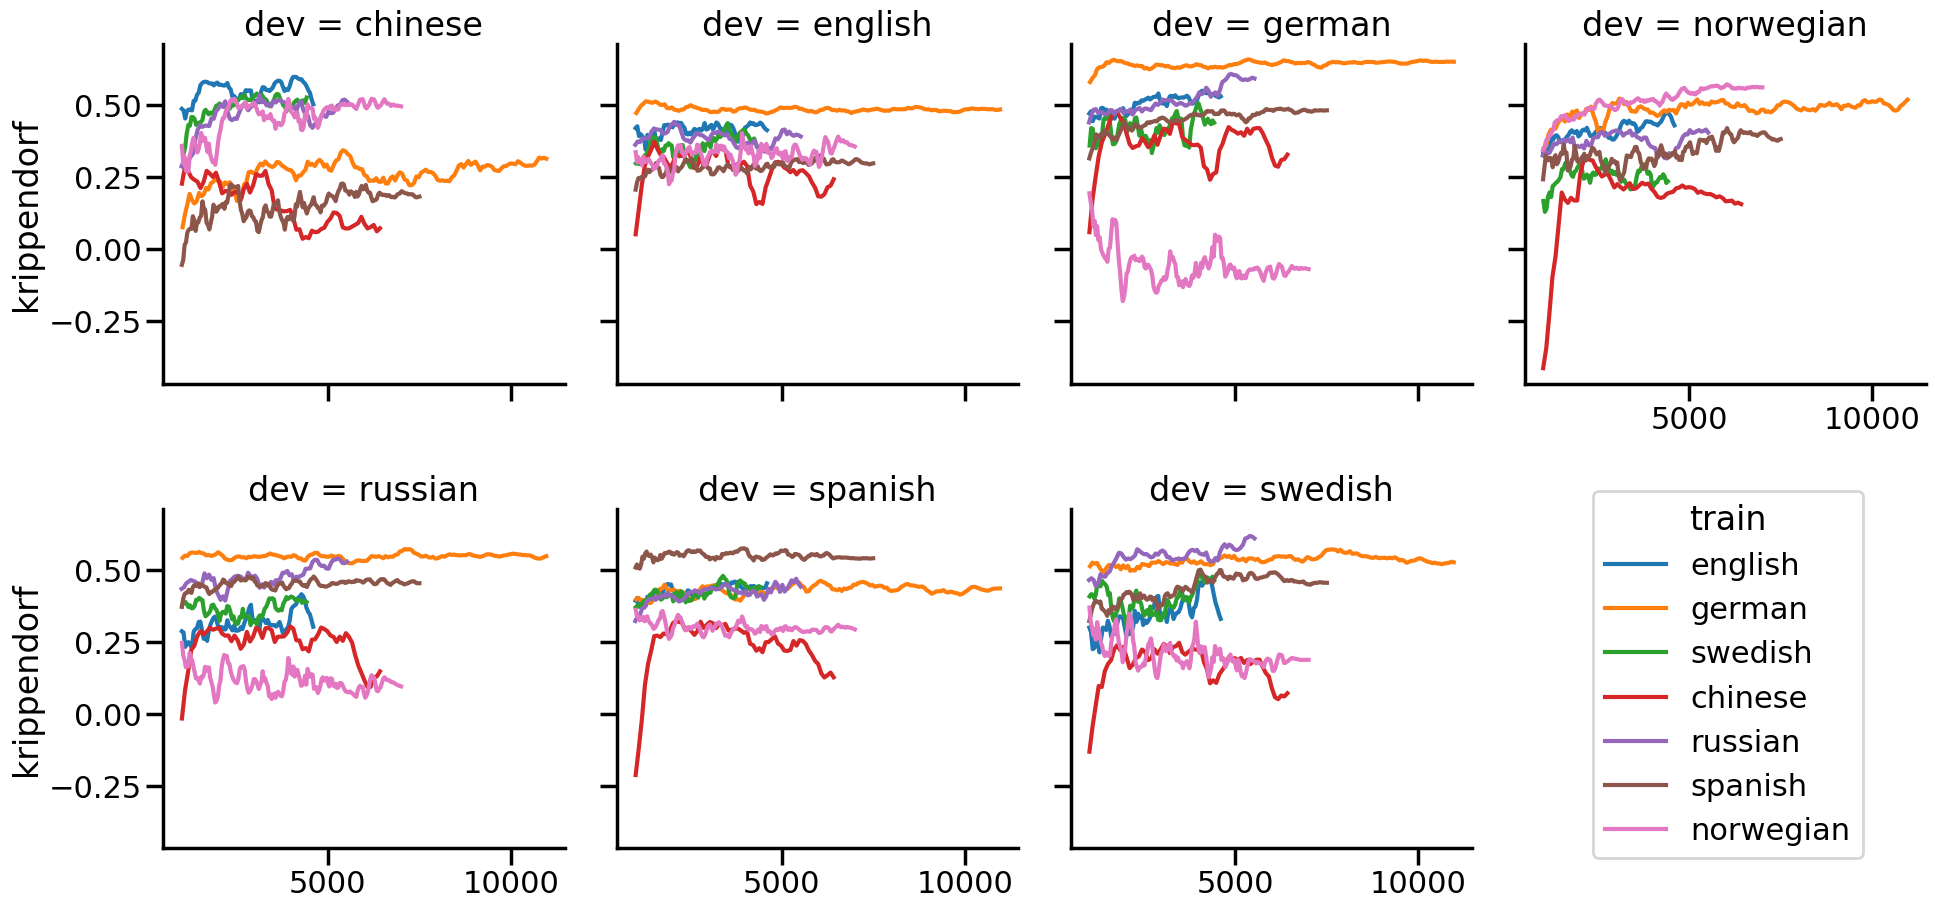

In [21]:
# pdf = df[df.tag.str.startswith('dev') & df.path.str.contains('without')].copy()
pdf = df[df.tag.str.startswith('dev') &
         ~df.path.str.contains('without') & ~df.path.str.contains('all')].copy()
pdf['dev'] = pdf.tag.str.extract('comedi_(.*).krippendorff')
pdf['train'] = pdf.path.str.extract('CoMeDi_([a-z]*)_4')
pdf['krippendorf'] = pdf.sort_values(by='step').groupby(['train','dev'])['value'].transform(lambda s:                                                                                              s.rolling(5).mean())

g = sns.relplot(data=pdf[pdf.step>1000], y='krippendorf', x='step', hue='train', col='dev', 
            kind='line', col_wrap=4)
sns.move_legend(g, 'lower right',  bbox_to_anchor=(0.85, 0.1), frameon=True)
g.set_xlabels('')
g.savefig('4class-one2one.pdf')

chinese: en / sw, ru, no / ge, sp, ch
english: ge / en, ru, sw / no, sp, ch
german: *ge, ru* / en, sw, sp / ch, no
norwegian: no, ge / en, ru, sp / sw, ch
russian: *ge, ru* / sp, sw, en / ch, no
spanish: sp / ge, sw, en / ch, no
swedish: *ru, ge* / sp, en, sw / ch, no

When optimizing for Krippendorrf's alpha, 

In [121]:
tdf = pdf.groupby(['train','test']).value.max().reset_index()

In [122]:
tdf = tdf.pivot_table(values='value', index='train', columns='test')
tdf

test,chinese,english,german,norwegian,russian,spanish,swedish
train,,,,,,,
chinese,0.375582,0.429521,0.535946,0.374146,0.392575,0.380121,0.355192
english,0.620573,0.500939,0.561946,0.499487,0.450086,0.508486,0.547743
german,0.368565,0.549398,0.674271,0.587103,0.580627,0.487972,0.588079
norwegian,0.569458,0.451697,0.341587,0.583238,0.363005,0.392027,0.450403
russian,0.592865,0.466873,0.614883,0.462023,0.561554,0.531269,0.650091
spanish,0.360754,0.362802,0.498823,0.449926,0.493418,0.595925,0.515043
swedish,0.575451,0.461504,0.540234,0.390414,0.447257,0.491902,0.549172


In [127]:
rdf = tdf.rank(axis=0, ascending=False)
rdf

test,chinese,english,german,norwegian,russian,spanish,swedish
train,,,,,,,
chinese,5.0,6.0,5.0,7.0,6.0,7.0,7.0
english,1.0,2.0,3.0,3.0,4.0,3.0,4.0
german,6.0,1.0,1.0,1.0,1.0,5.0,2.0
norwegian,4.0,5.0,7.0,2.0,7.0,6.0,6.0
russian,2.0,3.0,2.0,4.0,2.0,2.0,1.0
spanish,7.0,7.0,6.0,5.0,3.0,1.0,5.0
swedish,3.0,4.0,4.0,6.0,5.0,4.0,3.0


<Axes: xlabel='test', ylabel='train'>

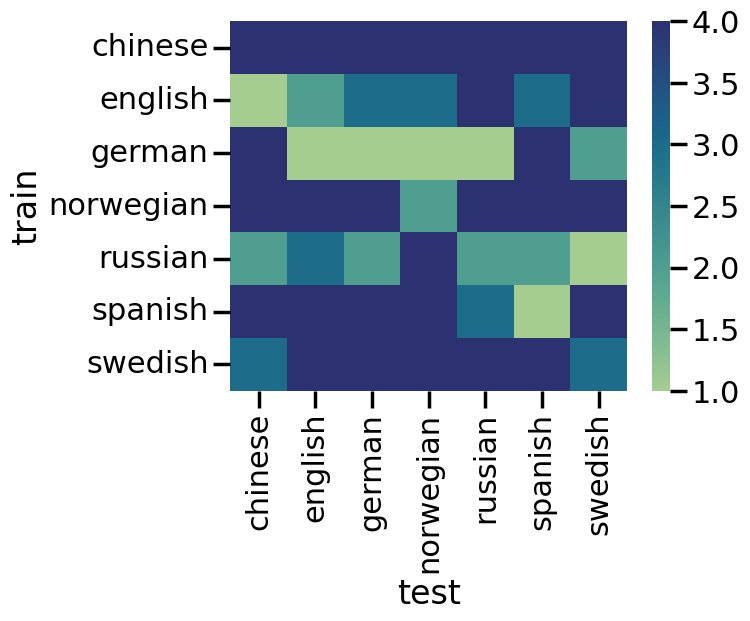

In [149]:
sns.heatmap(data=rdf, cmap='crest', vmax=4)

In [114]:
tdf.corr('spearman')

test,chinese,english,german,norwegian,russian,spanish,swedish
test,,,,,,,
chinese,1.000000,0.464286,0.285714,0.035714,-0.142857,0.107143,0.321429
english,0.464286,1.000000,0.857143,0.642857,0.535714,0.000000,0.714286
german,0.285714,0.857143,1.000000,0.321429,0.785714,0.178571,0.821429
norwegian,0.035714,0.642857,0.321429,1.000000,0.357143,0.000000,0.357143
russian,-0.142857,0.535714,0.785714,0.357143,1.000000,0.571429,0.785714
spanish,0.107143,0.000000,0.178571,0.000000,0.571429,1.000000,0.500000
swedish,0.321429,0.714286,0.821429,0.357143,0.785714,0.500000,1.000000


In [122]:
tdf

NameError: name 'tdf' is not defined